# 2 - LeNet

In this notebook, we implement a modified [LeNet-5](http://yann.lecun.com/exdb/lenet/), a model with convolutional neural network (CNN) layers designed for [classifying handwritten characters](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). CNNs are ubiquitous in modern computer vision. Almost every neural-network model for computer vision contains many CNN layers, thus they're important to understand. We explain how they work as we implement the model.

The image below shows the architecture of LeNet-5. It consists of two convolutional layers, each followed by a subsampling layer, and then three fully connected linear layers.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)

Like the previous notebook, we'll implement LeNet, measure its performance on the MNIST dataset, and then look into what the model has learned.

Most of this notebook is similar to the previous one, thus we skim over code shown previously. Look at the previous notebook for a refresher.

### Data Processing

Import the neede modules.

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

Set the random seed for reproducability.

In [64]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Calculate the mean and standard deviation across the training set for normalization.

In [65]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


Define the train and test transforms...

In [66]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

Load train and test data.

In [67]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

Create a validation set from 10% of the training data.

Remember that the validation set should always be taken from the training data, and never from the test data.

In [68]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

The validation set has the same transforms as the training set. We want our validation set to remain static, to better resemble our test set, we replace its train transform with the test transforms - remembering to `deepcopy` the validation set.

In [69]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

Print out the number of examples in the training/validation/test sets to ensure everything has been loaded correctly.

In [70]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


The final part of the data-processing stage is to create dataloaders/iterators.

Again, we set batch size to 64 and only shuffle the training data each epoch.

In [71]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Defining the Model

Each convolutional layer has a number of *filters*, also called *kernels*. A filter is a (usually) square matrix that slides across the pixels in an image from left-to-right, top-to-bottom. At each "step", the filter performs a [convolution](https://en.wikipedia.org/wiki/Convolution) operation on the image. The output of the convolutional layer is the result of these convolutions after the filter's final "step". 

**Note:** in machine-learning frameworks, there aren't actually "steps." The result for every filter location is calculated at the same time, in parallel. This is a lot faster than actually stepping through the image, but thinking about it in terms of steps makes everything easier to visualize.

Look at a single 2x2 filter passing over an image. Pretend the image is 10x10 pixels.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/filter-mnist.png?raw=1)

The filter (red) slides over the pixels of the image, stepping one pixel at a time. The size of the steps is the *stride*. This example has a stride of one, meaning the filter moves one pixel at a time horizontally and moves one pixel down once it reaches the end of a row. The result of the convolution operation (green) is a pixel in the filtered image. A convolution produce a new, filtered image.

Notice how the image coming out of the CNN layer is smaller than the image coming into the CNN. This is because the 2x2 filter has only nine steps horizontally and vertically. If we wanted to keep the output image the same size as the input image, we could add padding - usually black pixels - around our image. 

When we have no padding and a step size of one, the size of the output image is: 

$$\text{height}_{\text{out}} = \text{height}_{\text{in}} - \text{filter}_{\text{height}} + 1$$

$$\text{width}_{\text{out}} = \text{width}_{\text{in}} - \text{filter}_{\text{width}} + 1$$

How do we calculate the values of the output pixels using the filter? Multiplying and adding! Each pixel of the input covered by a filter is multiplied by the filter's weight over that pixel. These products are summed to get the value of the pixel in the output image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-filter.png?raw=1)

Filter weights do not change with the filter's location within the image. One nice thing about this is that the filters (and the convolutional layers themselves) are *translation-invariant*, meaning that it doesn't matter where a feature (curve, edge, line) appears in an image, the convolutional layer will find all occurrences of it. 

The weights for the filters, much like the weights of the linear layers in multilayer perceptrons, are learned via gradient descent and backpropagation.

Why are convolutional neural networks structured in this way? Filters applied across an image can detect patterns such as horizontal and vertical lines. Think of these patterns as features of the image that a CNN extracts. Combine these extracted features in further layers of the neural network with other extracted features, together forming higher-level features, e.g. positions and orientations of two lines to make a cross, which can indicate the centre of a handwritten 4.

CNNs are inspired by classic computer vision techniques, like [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator). Let's manually choose weights of a 3x3 Sobel filter and apply them to some MNIST digits to visualize the types of things that CNN layers can learn.

The `plot_filter` function takes a batch of images and a two-dimensional filter and plots the output of that filter applied to all of the images.

In [74]:
def plot_filter(images, filter_):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    
    filter_ = torch.FloatTensor(filter_).unsqueeze(0).unsqueeze(0).cpu()

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter_)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Filtered')
        ax.axis('off')

Gget a batch of images from the test set to test the handwritten Sobel filters. They're easier to examine because they don't have random transforms.

In [75]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

The first filter detects horizontal lines.

On the filtered images, the highest values (the whitest pixels) are where there is a horizontal line black on top and white below, e.g. the top of the 7 digit (! that looks white on top and black below to me). The lowest values (the blackest pixels) of the filtered image are where there is a horizontal line that goes from white to black, e.g. the bottoms of all the digits.

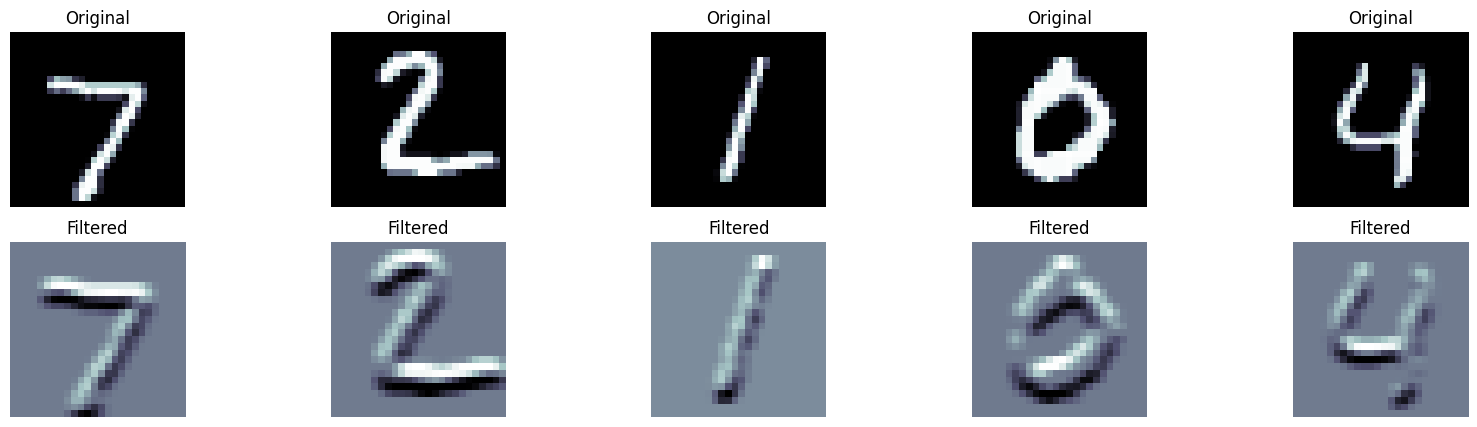

In [76]:
horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

By swapping the first and last rows of the above filter, we get a filter that detects horizontal lines from white on top to black underneath.

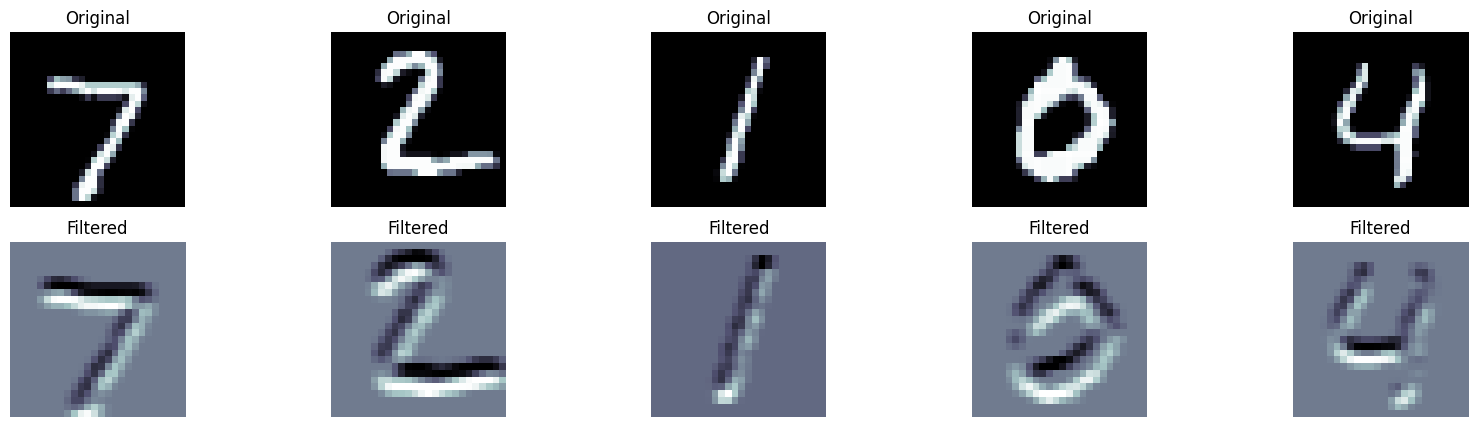

In [77]:
horizontal_filter = [[ 1,  2,  1],
                     [ 0,  0,  0],
                     [-1, -2, -1]]

plot_filter(images, horizontal_filter)

We can design filters that detect vertical lines. 

Here's one that detects vertical lines that are black on the left and white on the right.

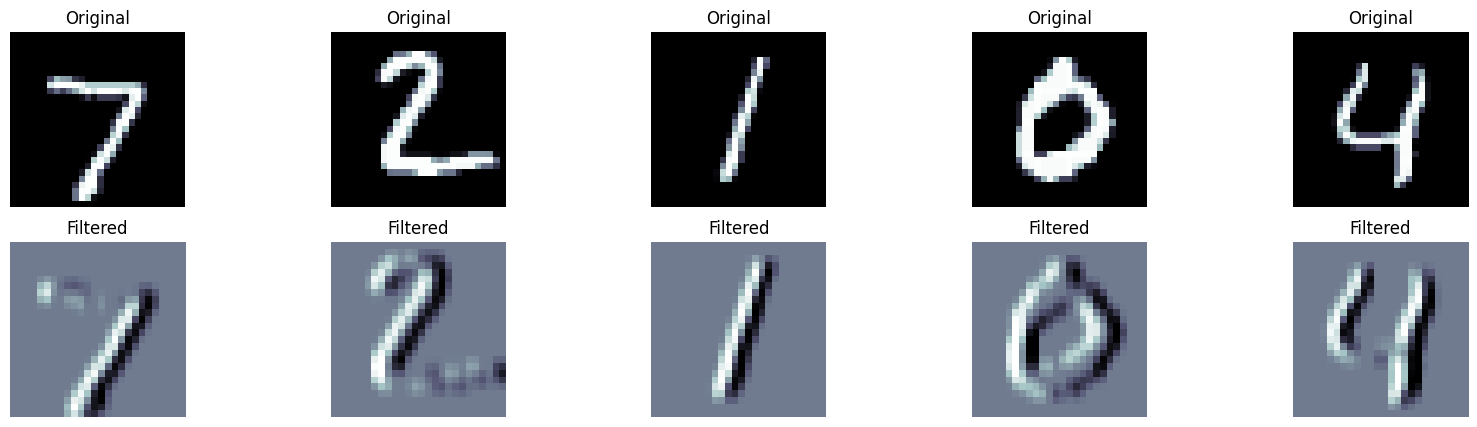

In [78]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

To get the opposite filter, one that detects vertical lines that are white on the left and black on the right, we swap the left and right columns.

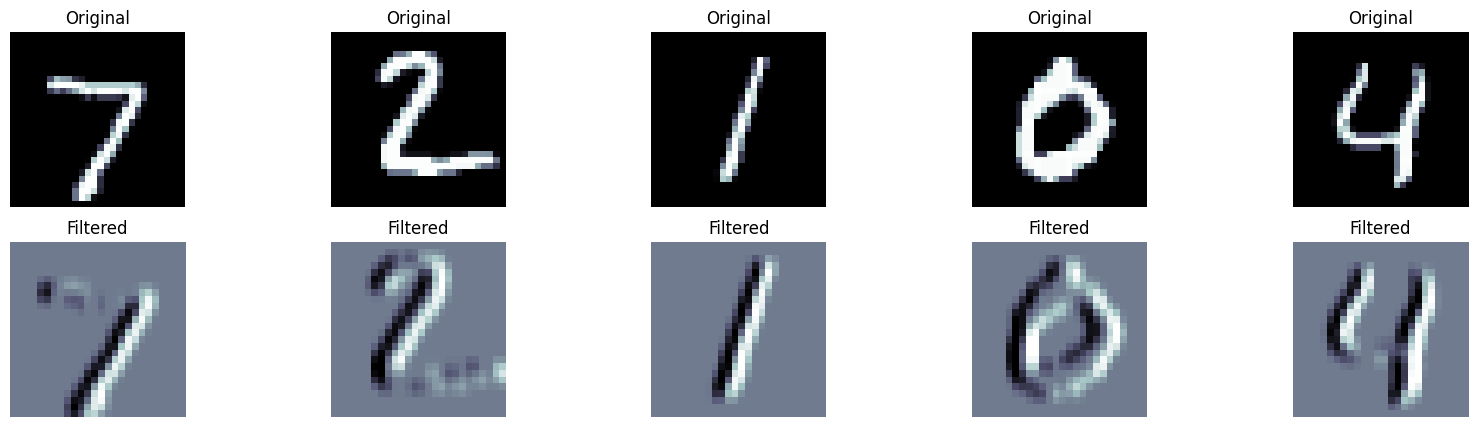

In [79]:
vertical_filter = [[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]]

plot_filter(images, vertical_filter)

Finally, we'll design a diagonal-detecting filter. This one detects lines pointing towards the top right of the image.

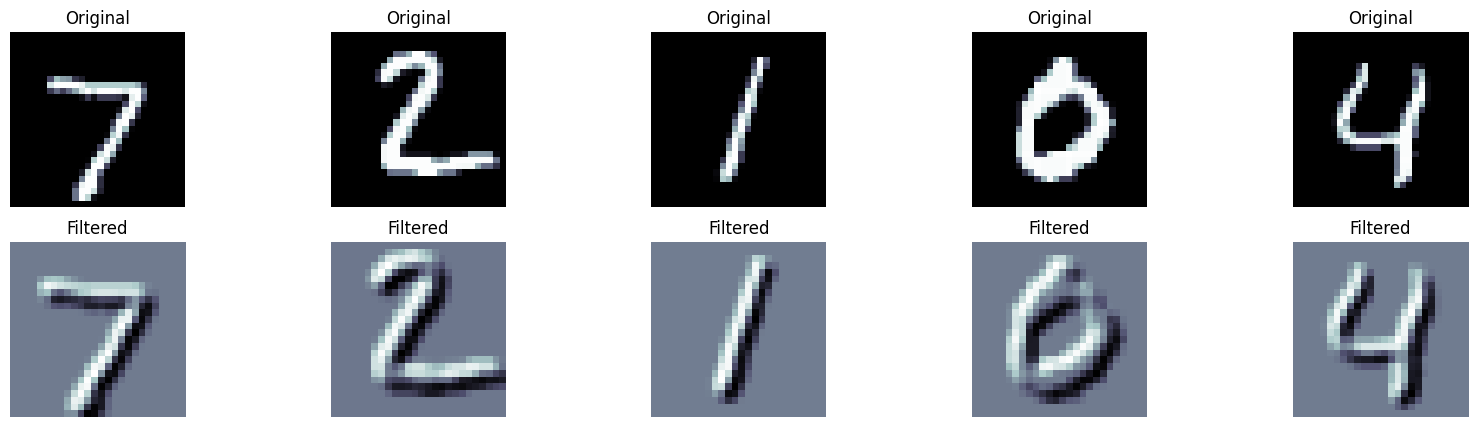

In [80]:
diagonal_filter = [[-2, -1, 0],
                   [-1,  0, 1],
                   [ 0,  1, 2]]

plot_filter(images, diagonal_filter)

The great thing about convolutional layers is that each layer doesn't just have a single filter. It has as many filters as you want. Each filter has its own weights, so (in theory) learns to extract different features. 

The image below shows the results of a convolutional layer with five filters. The original image with a single color channel (as it's black and white) has five filters applied to it to get five filtered images. These images are then stacked together to get what we can think of as a single image with five channels.  

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-filter-mnist.png?raw=1)

Suppose you now want to pass this five-channel filtered image to another convolutional layer? That convolutional layer won't just have a height and a width, but it will also have a depth equal to the number of channels in the input image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-channel-mnist.png?raw=1)

The filter has a height, width, and depth of 2x2x5. All the 20 pixel values covered by this filter are multiplied by the filter's weight and then summed. The result has as many channels as there are filters. A subsequent convolutional layer must have filters with depths equal to that number of channels.

Hopefully that's enough on convolutional layers, but if not, there are [plenty](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) of [other](https://cs231n.github.io/convolutional-networks/) resources [about](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) them [online](https://www.coursera.org/learn/convolutional-neural-networks).

Next, consider the subsampling layers, which reduce the size/resolution of their input. They are commonly applied to the output of convolutional layers. The two most common subsampling methods are *max pooling* and *mean pooling* (also known as *average pooling*), and thus subsampling is often know as *pooling*.

Why reduce the resolution of the image? It speeds up our model, as convolution operations are expensive. If we subsample and halve the size of an image before it passes into the next convolutional layer, that's a significant speed-up.

Subsampling layers aren't too different to convolutional layers. They have a filter with a size and a stride. However, pooling layers do not have any learnable parameters - no weights and biases. They simply perform an operation on the image. Max pooling returns the maximum of the values covered by the filter. Think of it as extracting the single most important feature under the filter. Mean/average pooling returns the mean/average of the values covered by the filter. Think of it as equally weighting all features under the filter.

Look at a 2x2 pooling operation, with a stride of 2, over an image:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/subsample-mnist.png?raw=1)

Commonly, and by default in PyTorch, the stride for the height and the width is the height and the width of the filter and each pixel is only seen by the pooling layer once, thus:

$$\text{height}_{\text{out}} = \frac{\text{height}_\text{in}}{\text{filter}_{\text{height}}}$$

$$\text{width}_{\text{out}} = \frac{\text{width}_\text{in}}{\text{filter}_{\text{width}}}$$

For max pooling, the value of the output for each filter location is:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-pool.png?raw=1)

Define a function for visualizing the outputs of a pooling layer on a batch of images.

In [81]:
def plot_subsample(images, pool_type, pool_size):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')

    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size=pool_size)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Subsampled')
        ax.axis('off')

First, let's see max pooling with a filter size of 2. 

We can see that the image is heavily downsampled - reduced in size/resolution and in quality.

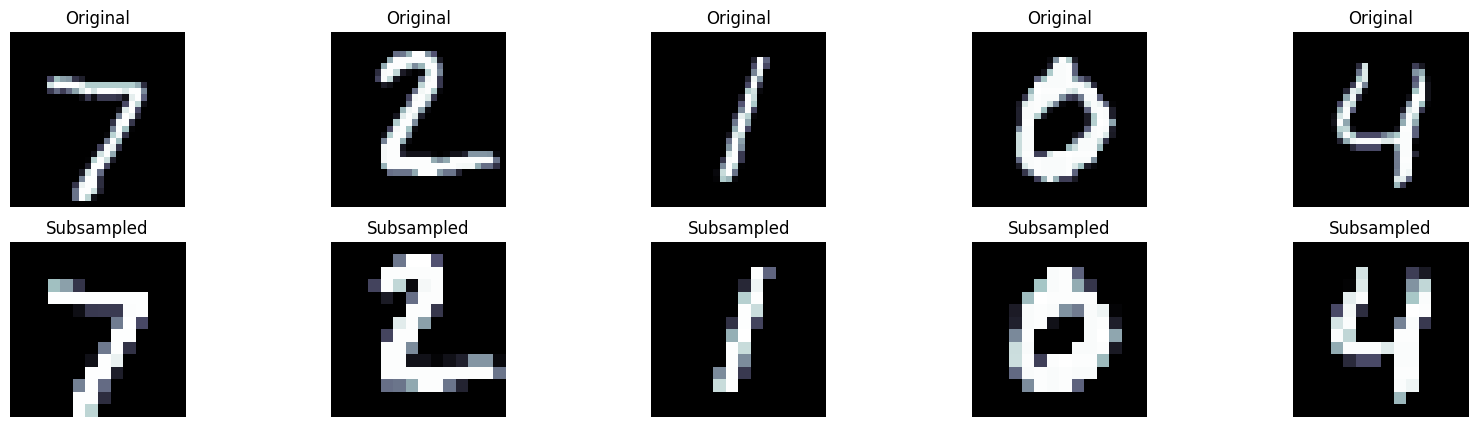

In [82]:
plot_subsample(images, 'max', 2)

If we increase the size of the max pooling filter, the images get smaller and the quality gets worse.

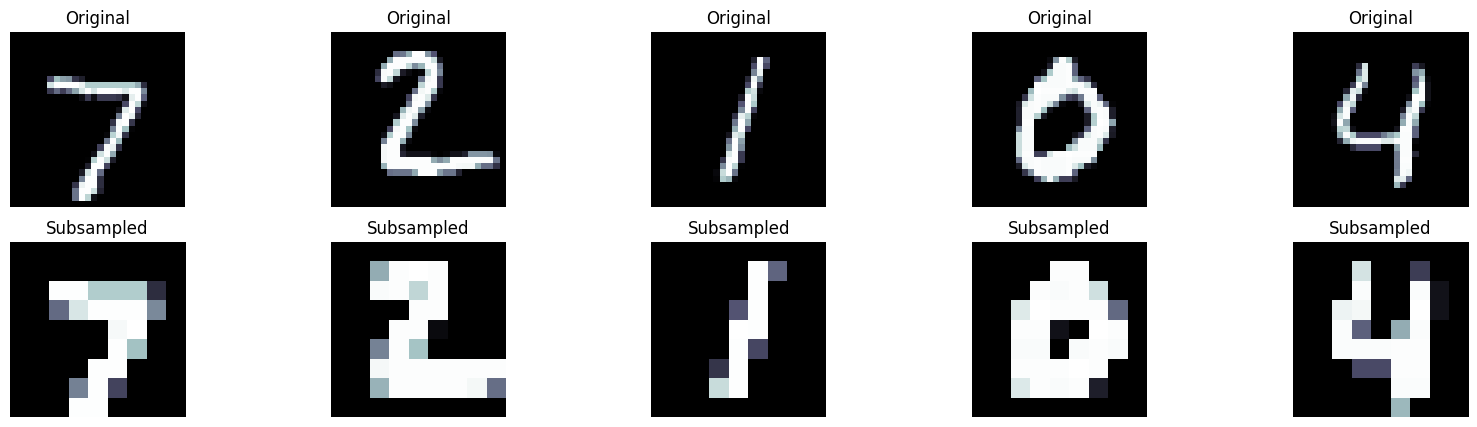

In [83]:
plot_subsample(images, 'max', 3)

For average pooling, the same effect happens, however the loss in quality is not as harsh.

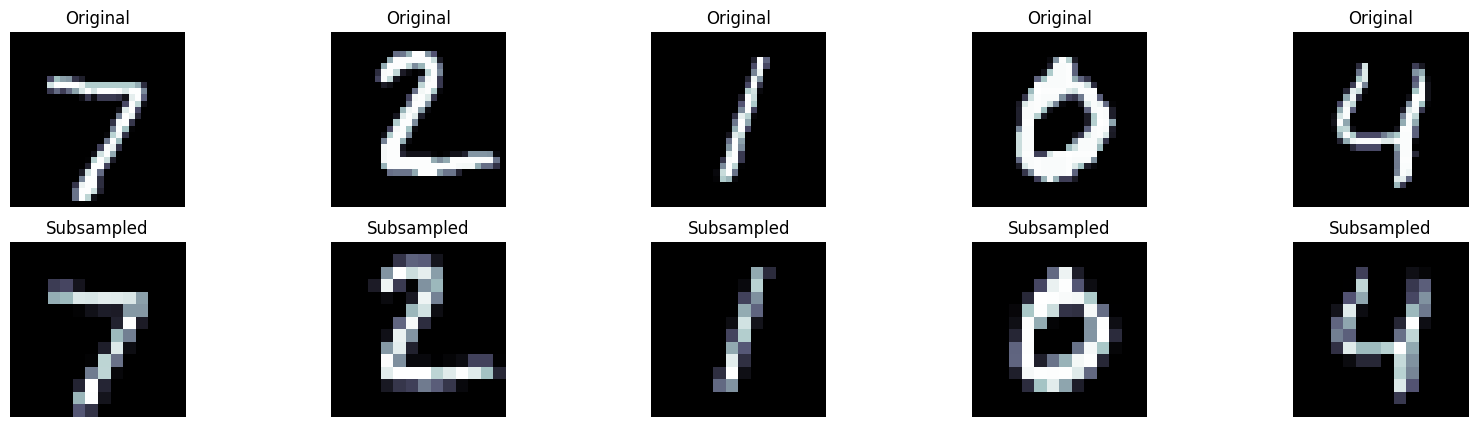

In [84]:
plot_subsample(images, 'avg', 2)

Again, we can increase the filter size, reducing the resolution of the output image at the cost of image quality - however, the quality drop is not as bad as with max pooling.

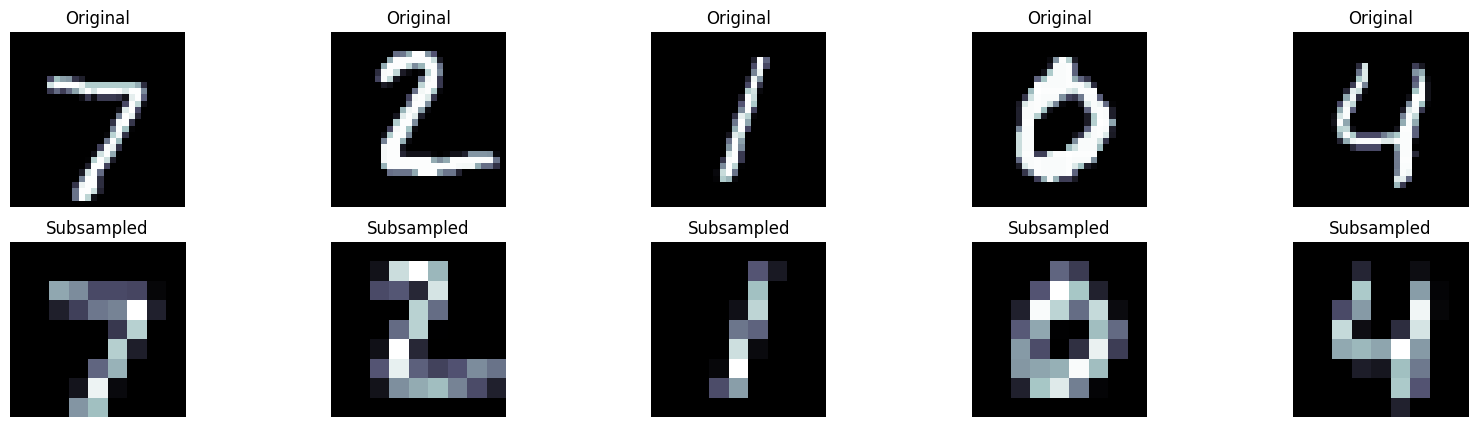

In [85]:
plot_subsample(images, 'avg', 3)

Similarly to convolutional layers, if the input image has more than one channel, the filter has a depth equal to the number of channels. Thus, if we did a max pool with a 5x5x6 filter (height and width of 5 and depth of 6), the output at each pixel would be the maximum value of all 150 pixels covered by the filter.

### Defining the Model

Now we've gone through all the concepts, we can implement a model.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)

Our implementation differs from the published LeNet architecture, which handles 32x32 images, whereas the MNIST dataset has 28x28 images. We also don't use the Gaussian connections at the end, just a standard linear layer.

The first layer in our model is a convolutional layer with 6 filters (PyTorch calls them `out_channels`) and a kernel size of 5. This turns our `[1, 28, 28]` image into `[6, 24, 24]`. We then downsample our image with a max-pooling layer with a filter size of 2 to get a `[6, 12, 12]` image. This is then passed through a ReLU activation function, which is applied elementwise and does not change the shape or depth of the image. 

Afterwards, we pass the image to the second convolutional layer with 16 5x5x6 filters, yielding an image size of `[16, 8, 8]` which we then max pool to half the height and width to `[16, 4, 4]` and then pass through another ReLU.

We then flatten our `[16, 4, 4]` image to `[256]` and pass this through three linear layers. Each of the linear layers are followed by another ReLU, except for the last.

We return the results from the final linear layer as well as from the flattened result of the second convolutional layer, which we can plot in lower dimensions later.

Always apply activation  **after** pooling. You will get the exact same results if you apply activation before, but activation after the image is reduced in size uses less computation.

In [86]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(16 * 4 * 4, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):

        # x = [batch size, 1, 28, 28]

        x = self.conv1(x)

        # x = [batch size, 6, 24, 24]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 6, 12, 12]

        x = F.relu(x)

        x = self.conv2(x)

        # x = [batch size, 16, 8, 8]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 16, 4, 4]

        x = F.relu(x)

        x = x.view(x.shape[0], -1)

        # x = [batch size, 16*4*4 = 256]

        h = x

        x = self.fc_1(x)

        # x = [batch size, 120]

        x = F.relu(x)

        x = self.fc_2(x)

        # x = batch size, 84]

        x = F.relu(x)

        x = self.fc_3(x)

        # x = [batch size, output dim]

        return x, h

The rest of the notebook is similar to the previous ones.

Create an instance of the model.

In [87]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

Calculate the number of parameters. 

Notice that this model has significantly fewer parameters than the previous model: 44,000 parameters compared to 222,000.

In [88]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,426 trainable parameters


### Training the Model

Define the optimizer...

In [89]:
optimizer = optim.Adam(model.parameters())

Define the loss function (which also applies softmax activation)

In [90]:
criterion = nn.CrossEntropyLoss()

Find the GPU, if we have one.

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Place the model and criterion on the device.

In [92]:
model = model.to(device)
criterion = criterion.to(device)

Define a function to calculate accuracy.

In [93]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Define a training epoch.

In [94]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Define an evaluation epoch.

In [95]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Measure run time of an epoch.

In [96]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Begin training!

Even though we have significantly fewer parameters, the model still takes around the same amount of time per epoch (convolutional layers are computationally expensive) and we train it a bit longer.

However, we beat the ~98% validation accuracy achieved by the multilayer perceptron model and achieve 99% validation accuracy.

In [97]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 13s
	Train Loss: 0.419 | Train Acc: 86.47%
	 Val. Loss: 0.115 |  Val. Acc: 96.61%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.137 | Train Acc: 95.71%
	 Val. Loss: 0.081 |  Val. Acc: 97.62%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 14s
	Train Loss: 0.101 | Train Acc: 96.83%
	 Val. Loss: 0.072 |  Val. Acc: 97.88%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 14s
	Train Loss: 0.085 | Train Acc: 97.39%
	 Val. Loss: 0.064 |  Val. Acc: 98.02%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 13s
	Train Loss: 0.069 | Train Acc: 97.77%
	 Val. Loss: 0.057 |  Val. Acc: 98.21%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 14s
	Train Loss: 0.065 | Train Acc: 97.89%
	 Val. Loss: 0.060 |  Val. Acc: 98.23%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 13s
	Train Loss: 0.060 | Train Acc: 98.15%
	 Val. Loss: 0.048 |  Val. Acc: 98.70%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 13s
	Train Loss: 0.052 | Train Acc: 98.38%
	 Val. Loss: 0.047 |  Val. Acc: 98.54%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 13s
	Train Loss: 0.052 | Train Acc: 98.36%
	 Val. Loss: 0.049 |  Val. Acc: 98.58%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 13s
	Train Loss: 0.046 | Train Acc: 98.54%
	 Val. Loss: 0.043 |  Val. Acc: 98.85%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 13s
	Train Loss: 0.046 | Train Acc: 98.56%
	 Val. Loss: 0.044 |  Val. Acc: 98.74%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 13s
	Train Loss: 0.044 | Train Acc: 98.63%
	 Val. Loss: 0.046 |  Val. Acc: 98.80%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 13s
	Train Loss: 0.042 | Train Acc: 98.71%
	 Val. Loss: 0.047 |  Val. Acc: 98.70%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 13s
	Train Loss: 0.041 | Train Acc: 98.73%
	 Val. Loss: 0.042 |  Val. Acc: 98.94%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 13s
	Train Loss: 0.040 | Train Acc: 98.73%
	 Val. Loss: 0.042 |  Val. Acc: 98.92%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 13s
	Train Loss: 0.036 | Train Acc: 98.82%
	 Val. Loss: 0.044 |  Val. Acc: 98.78%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 13s
	Train Loss: 0.035 | Train Acc: 98.88%
	 Val. Loss: 0.036 |  Val. Acc: 98.99%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 13s
	Train Loss: 0.035 | Train Acc: 98.93%
	 Val. Loss: 0.044 |  Val. Acc: 98.78%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 13s
	Train Loss: 0.032 | Train Acc: 98.99%
	 Val. Loss: 0.041 |  Val. Acc: 98.85%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 13s
	Train Loss: 0.032 | Train Acc: 98.94%
	 Val. Loss: 0.037 |  Val. Acc: 99.02%


Load the parameters that performed the best on the validation set and evaluate performance on the test set.

Just as with validation accuracy, we get 99% test accuracy!

In [98]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.027 | Test Acc: 99.19%


### Examining the Model

Much as in the previous notebook, examine the model via a confusion matrix, seeing which incorrect examples our model was most confident about, viewing the model's learned representations in two dimensions with PCA and t-SNE, and viewing the weights of the model.

First, get the model's predictions across the test set...

In [99]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [100]:
images, labels, probs = get_predictions(model, test_iterator, device)

Get predicted labels.

In [101]:
pred_labels = torch.argmax(probs, 1)

Plot the confusion matrix.

In [102]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

The only real problem the model seemed to have is predicting 2s as 7s (! I don't see that below; looks like 9s are read as 4s 15 times and 5s as 3s 7 times)

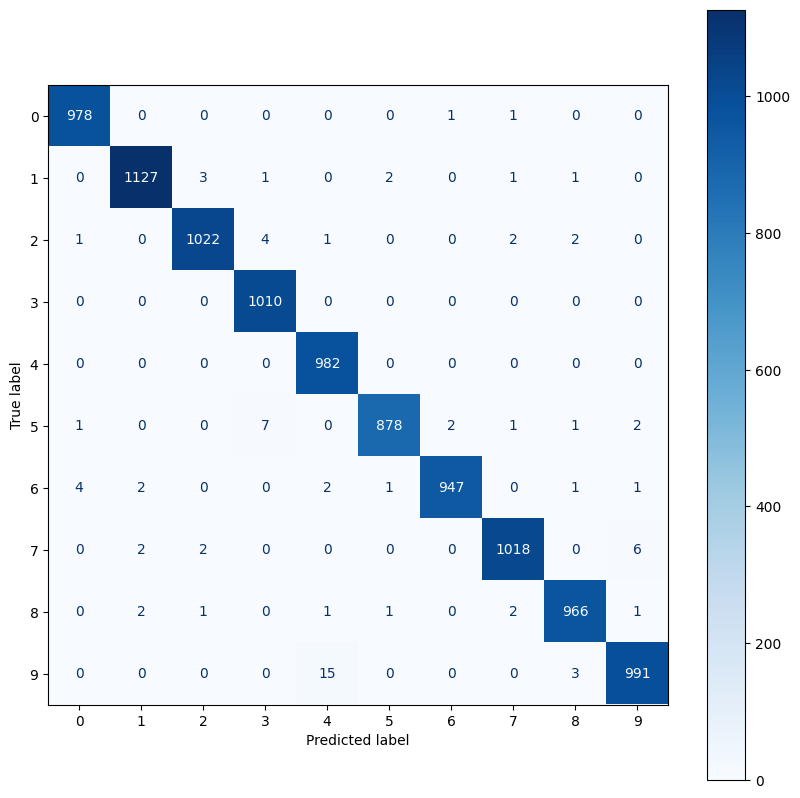

In [104]:
plot_confusion_matrix(labels, pred_labels)

Find out which examples are correct.

In [105]:
corrects = torch.eq(labels, pred_labels)

Get all incorrect examples and sort by descending prediction confidence.

In [106]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

Pltt the examples the model got wrong with high confidence.

In [107]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

The mistakes look pretty reasonable. All the digits shown here are a bit off.

As mentioned in the previous notebook, the model is always trained to be confident with its predictions, even when it's wrong.

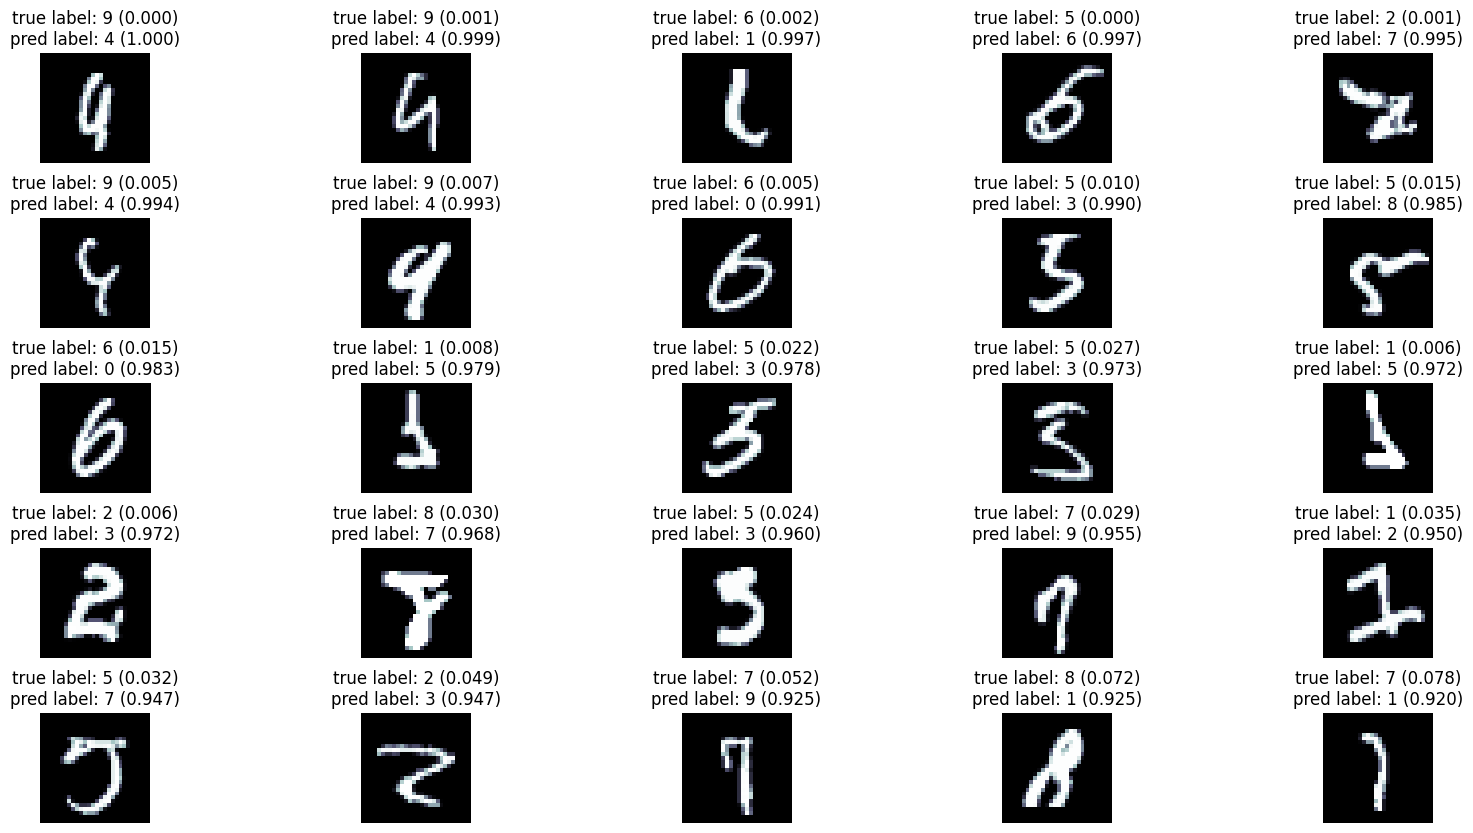

In [108]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

Move on to plotting the model's representations in lower dimensions for visualization.

Get the representations from the model...

In [109]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [110]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/844 [00:00<?, ?it/s]

Calculate PCA on the representations.

In [111]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [112]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

Plot the PCA representations. 

Similar to the previous notebooks, even when the classes overlapped in the PCA representations, the confusion matrix showed that they weren't mixed up often at all.

In [113]:
output_pca_data = get_pca(outputs)

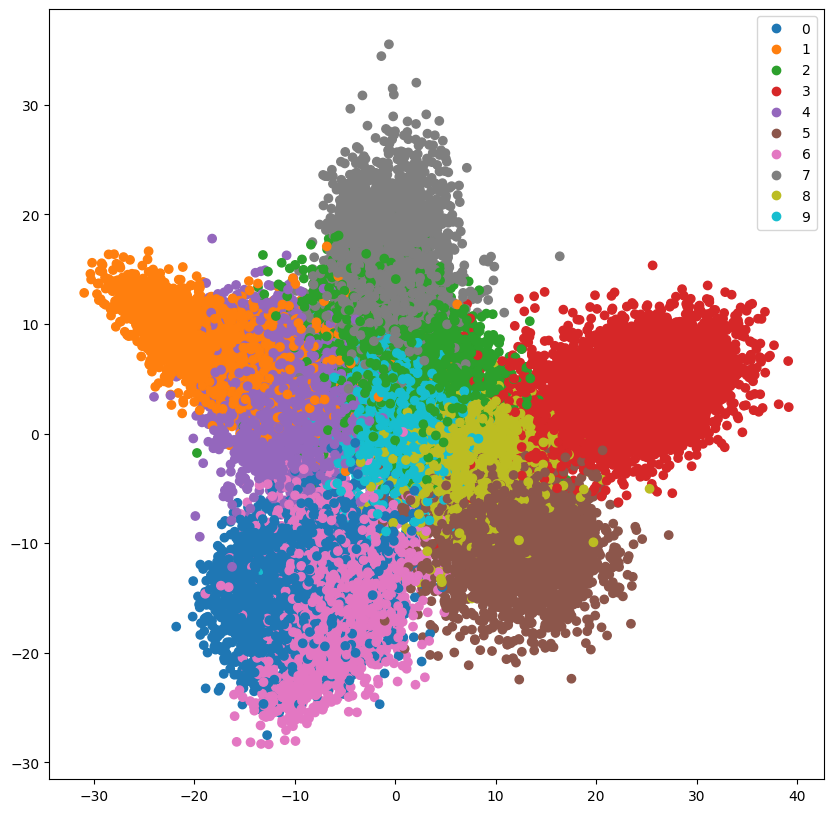

In [114]:
plot_representations(output_pca_data, labels)

Plot the PCA representations of the intermediate values, just after the second set of convolutional and subsampling layers.

A lot of the classes are overlapped in one giant cluster. Intuitively, this makes sense, as the model has only extracted the features of the image so far and not yet passed them to the linear layers that will weight these features to make an actual prediction.

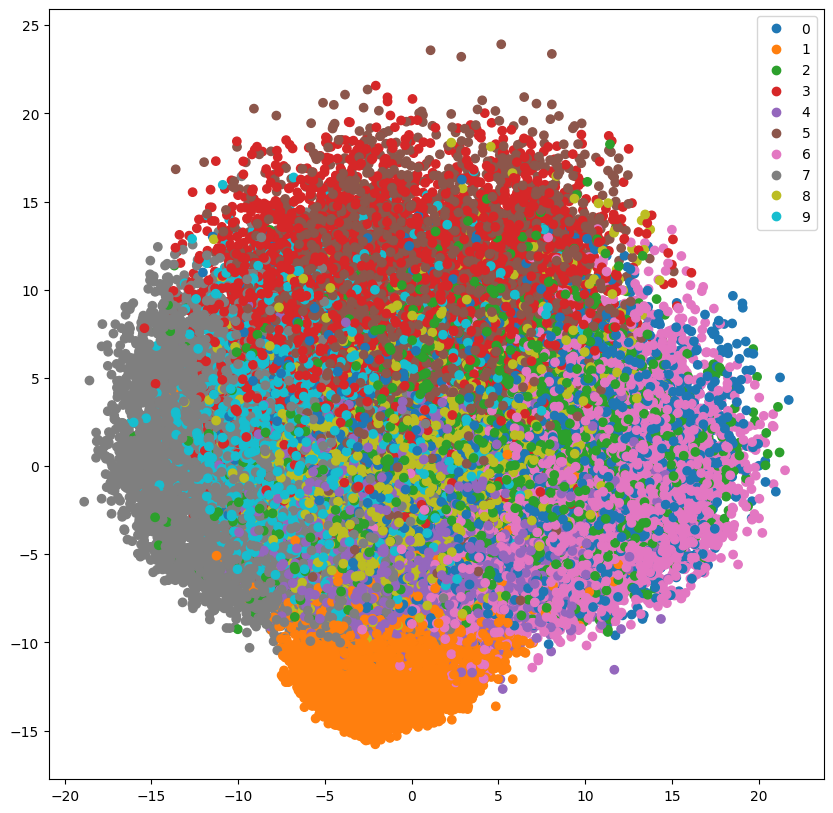

In [115]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

Repeat the process for t-SNE on a subset of the data, as t-SNE takes a long time.

In [116]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

First, the output representations. t-SNE does a good job on separating out the classes.

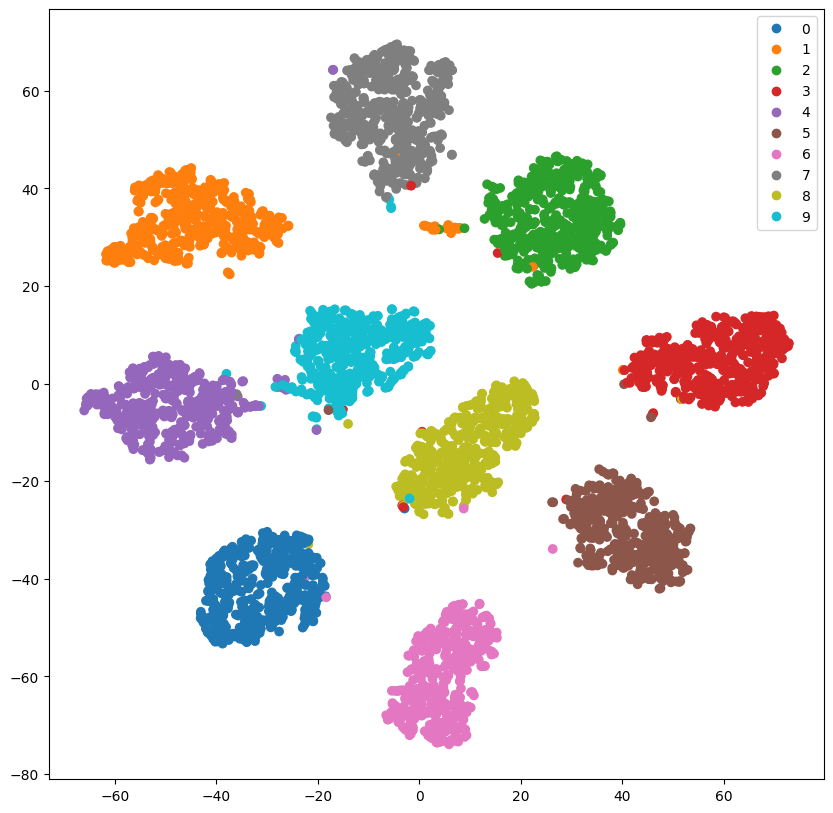

In [117]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

Again, the intermediate representations are more clustered, adding more evidence to the theory that this is just a representation of the extracted features before the linear layers weigh up evidence on the presence or absence of extracted features.

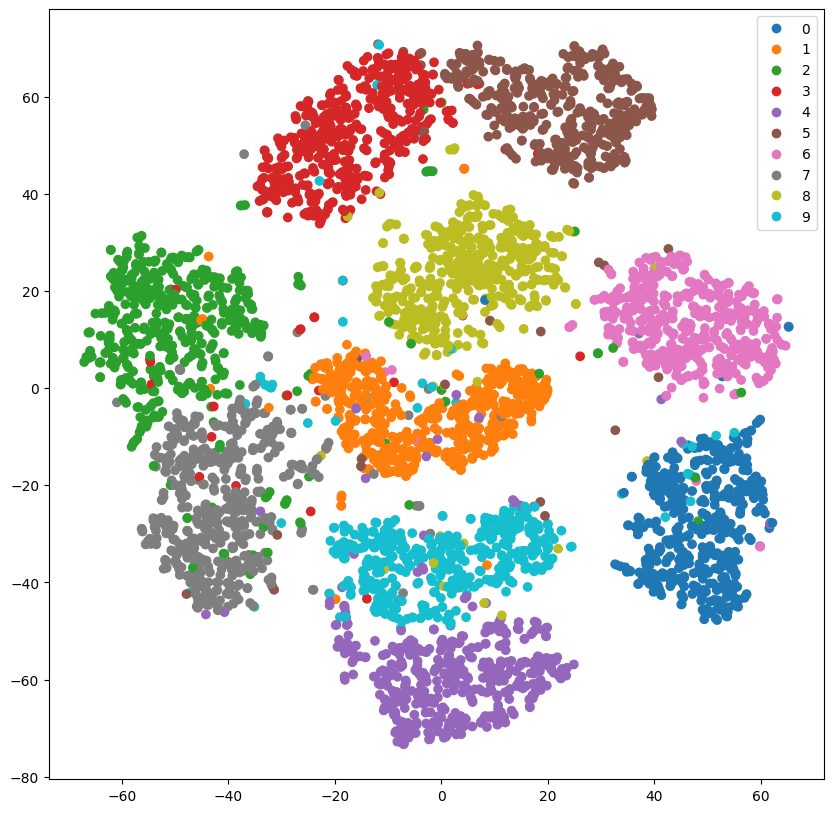

In [118]:
intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

As before, we can try generating a perfect handwritten digit by repeatedly generating a batch of noise and storing the noise that gave us the highest probability of being the digit we want. 

Surely as we now have convolutional layers that look for edges and curves we should get something more sensible, right?

In [119]:
def imagine_digit(model, digit, device, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 1, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

As we can see below, no. We get random noise with a >99% confidence that it's a three. 

Again, our model has been trained to be confident in its predictions, even for random noise. This is a flaw of neural networks and is a reason why [adversarial examples](https://openai.com/blog/adversarial-example-research/) work so well.

In [120]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [121]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 99.74%


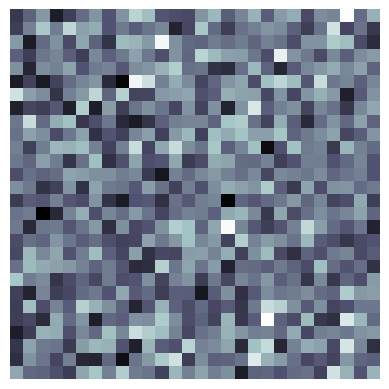

In [122]:
plt.imshow(best_image.squeeze(0).cpu().numpy(), cmap='bone')
plt.axis('off');

Remember how we defined the Sobel filters earlier? Well, as convolutional layers learn values for their filters, we can do the same thing and see how our filters process images.

Define a function that takes a batch of images and applies multiple filters.

In [123]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

Some of filters look for areas of black pixels, inverting the images. Some apply a blur effect, similarly to [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) in image processing to reduce noise. Some detect edges, like Sobel filters.

There is no guarantee each filter will learn a unique filtering effect. They are initialized randomly, and some filters may learn very similar weights. Therefore, it does not necessarily mean that using more filters will give better performance.

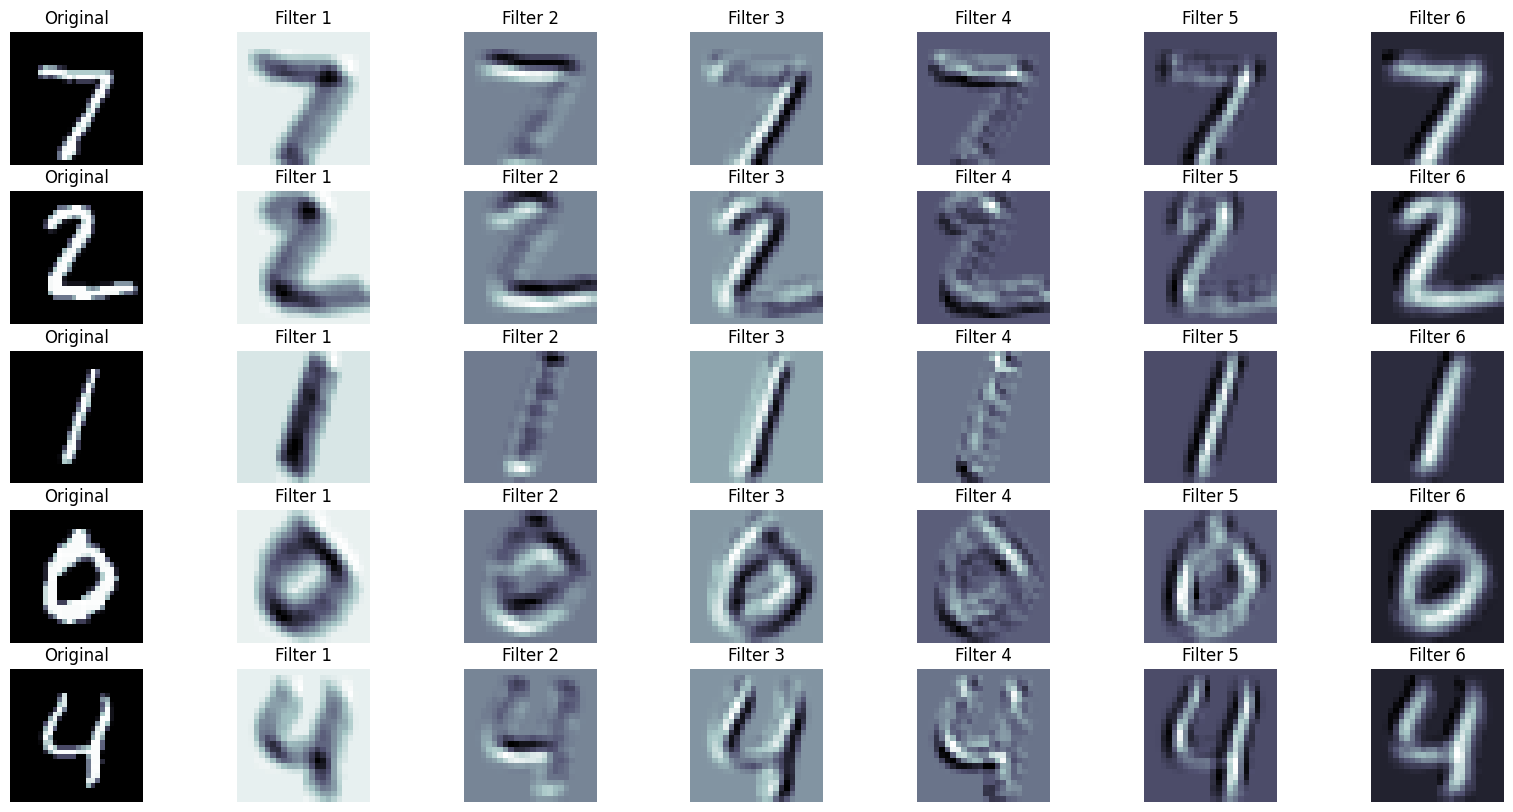

In [124]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters)

Let's see what the best imagined digit looks like after passing through our filters. 

We get some nice looking patterns, but that's about it. 

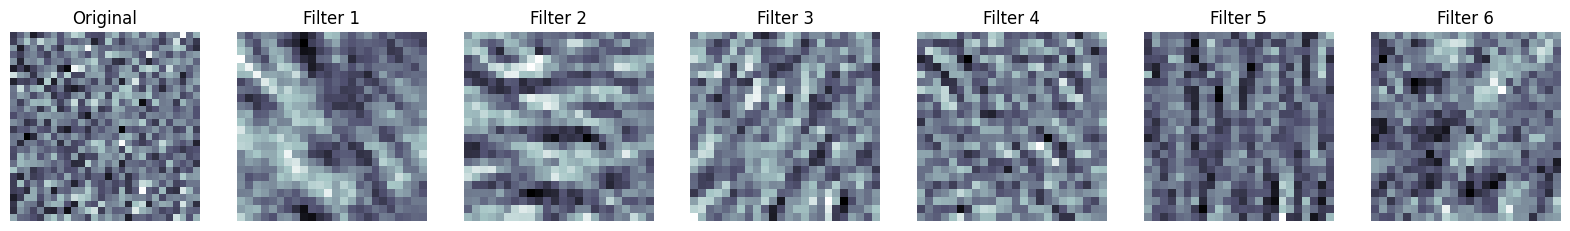

In [125]:
plot_filtered_images([best_image], filters)

Finally, plot the actual filters themselves.

In [126]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_filters):

        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filters[i].squeeze(0), cmap='bone')
        ax.axis('off')

There are some patterns visible, but it's difficult to interpret what these filters have actually learned.

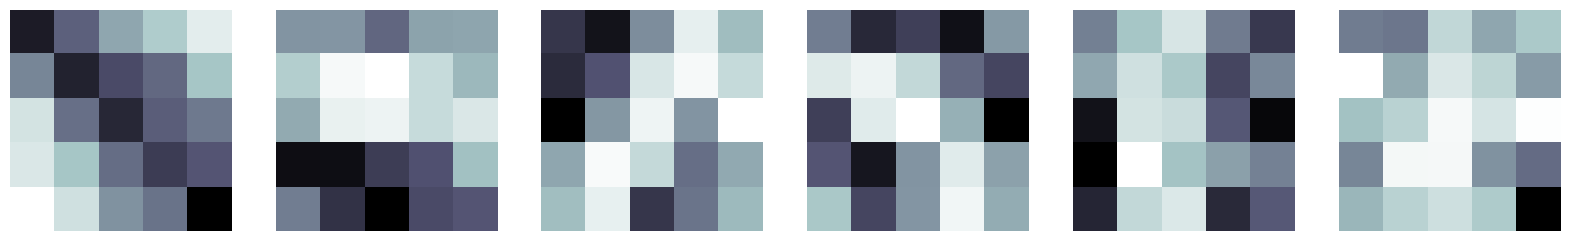

In [127]:
plot_filters(filters)

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize data
- what a convolutional layer is doing
- what a subsampling layer is doing
- defining a CNN (LeNet)
- training a model to achieve >98% accuracy
- viewing model mistakes
- visualizing data in lower dimensions with PCA and t-SNE
- generating fake digits
- viewing the learned weights of our model

In the next notebook we'll implement another CNN, AlexNet, and finally move on to color images by using the CIFAR10 dataset.